# Introduction

In this notebook, we apply Moran’s I to quantify the spatial autocorrelation. We then use folium map to see the spatial clusters, which highlight neighborhoods based on their eviction patterns: top 20%, above median, low eviction/mode. The viz offers a clear view of how eviction rates are geographically distributed.

Then, we used queen and rook methods. Both methods' moran's I are around 0.84, indicating a strong positive spatial autocorrelation. The p-values in both cases are also 0.001, further confirming the statistical significance of the spatial clustering pattern. Therefore, safe to conclude eviction data in nyc are geographically concentrated,

In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy esda splot

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

# sklearn stuff
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from shapely.geometry import Point
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

# Part 1: Get the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# data source:
# already cleaned gdf
# file_path = '/content/drive/My Drive/X999/evictions_cleaned.csv'
file_path1 = '/content/drive/My Drive/X999/evictions_covid.csv'
file_path2 = '/content/drive/My Drive/X999/evictions_pre_post_covid.csv'

In [10]:
evictions_covid_raw = pd.read_csv(file_path1)
eviction_pre_post_covid_raw = pd.read_csv(file_path2)

In [11]:
evictions_covid = evictions_covid_raw.copy()
eviction_pre_post_covid = eviction_pre_post_covid_raw.copy()
# easier to work around with a copy

# Part 4: Clustering Analysis

## Part 4.1 Moran's I analysis:

- Moran’s I Value: it ranges from -1 (perfect dispersion) to +1 (perfect clustering), with 0 indicating random spatial distribution.
- p-value: indicates the statistical significance of the result. A low p-value (here we want < 0.05) suggests that the observed spatial pattern is unlikely to have occurred by chance.
- only using DCSCAN clusters for later analysis

source: https://www.statisticshowto.com/morans-i/

In [14]:
evictions_covid.columns, \
eviction_pre_post_covid.columns

(Index(['court_index_number', 'docket_number', 'eviction_address',
        'eviction_apartment_number', 'executed_date', 'borough',
        'eviction_postcode', 'ejectment', 'eviction/legal_possession',
        'latitude', 'longitude', 'community_board', 'council_district',
        'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
        'year', 'average_year_eviction_count'],
       dtype='object'),
 Index(['court_index_number', 'docket_number', 'eviction_address',
        'eviction_apartment_number', 'executed_date', 'borough',
        'eviction_postcode', 'ejectment', 'eviction/legal_possession',
        'latitude', 'longitude', 'community_board', 'council_district',
        'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
        'year', 'average_year_eviction_count'],
       dtype='object'))

In [17]:
# re-touch the data for further analysis
k_covid = 2 # as decided by DBSCAN
evictions_covid['latitude'] = evictions_covid['latitude'].astype(float)
evictions_covid['longitude'] = evictions_covid['longitude'].astype(float)
evictions_covid['geometry'] = evictions_covid.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
# gdf = gpd.GeoDataFrame(evictions_cleaned, geometry='geometry')


In [18]:
# re-touch the data for further analysis
k = 3 # as decided by DBSCAN
eviction_pre_post_covid['latitude'] = eviction_pre_post_covid['latitude'].astype(float)
eviction_pre_post_covid['longitude'] = eviction_pre_post_covid['longitude'].astype(float)
eviction_pre_post_covid['geometry'] = eviction_pre_post_covid.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
# gdf = gpd.GeoDataFrame(evictions_cleaned, geometry='geometry')

In [30]:
w = Queen.from_dataframe(evictions_covid)
w.transform = 'r'

In [31]:
# using the weight, w, from above
# moran's I for the average_year_eviction_count column
# moran's I value and p-value
# it suggests strong correlation with fairly good confidence
attribute = evictions_covid['average_year_eviction_count'].values
moran = Moran(attribute, w)
print("results: covid moran's I:", moran.I, "p-value:", moran.p_sim)

results: covid moran's I: 0.526252423166464 p-value: 0.001


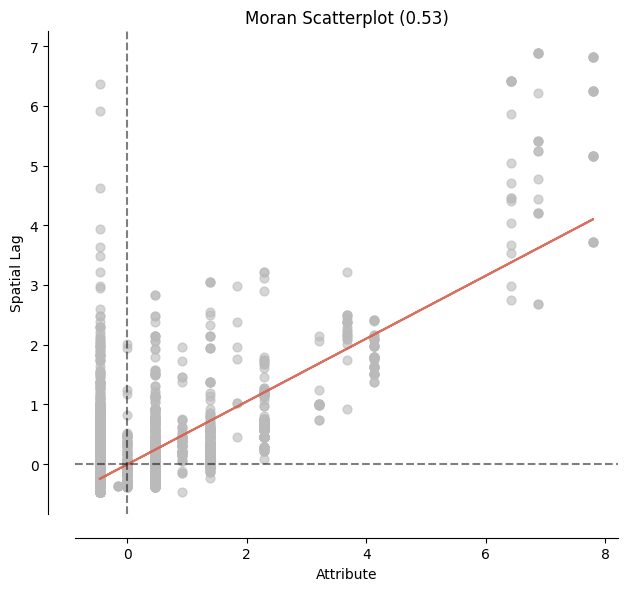

In [32]:
fig, ax = moran_scatterplot(moran)
plt.show()

In [26]:
w = Queen.from_dataframe(eviction_pre_post_covid)
w.transform = 'r'

In [28]:
# using the weight, w, from above
# moran's I for the average_year_eviction_count column
# moran's I value and p-value
# it suggests strong correlation with fairly good confidence
attribute = eviction_pre_post_covid['average_year_eviction_count'].values
moran = Moran(attribute, w)
print("results: outside of covid moran's I:", moran.I, "p-value:", moran.p_sim)

results: outside of covid moran's I: 0.8538279709771178 p-value: 0.001


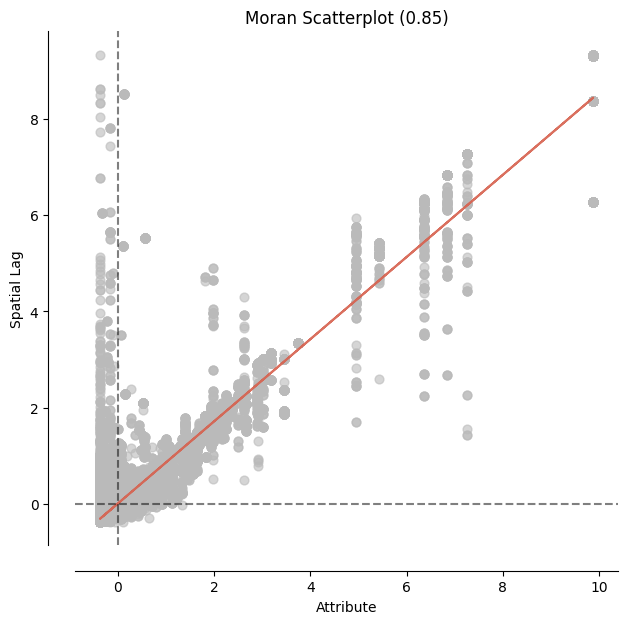

In [29]:
fig, ax = moran_scatterplot(moran)
plt.show()

- **Moran’s I > 0: positive spatial autocorrelation meaning similar values cluster together.**
- Moran’s I < 0: negative spatial autocorrelation meaning values disperse.
- **p-value < 0.05: significant spatial pattern.**
- Apparently, outside of covid, the similar values cluster is stronger.

#### **Short summaries: what do these Moran results mean?**

- The Moran's I value of 0.85 and a p-value of 0.001 (outside of covid) indicate a strong positive spatial autocorrelation. This suggests that areas with high eviction counts are likely to be surrounded by other areas with high eviction counts, and similarly for areas with low eviction counts.
- The moran's i value of 0.53 and a p-value of 0.001 (during covid) also indicates a somewhat strong positive spatial autocorrelation.

#### Running on Folium again to visualize everything on a map
##### Also generate a map with selective dots on the map for clarity

In [33]:
threshold_80_percentile = eviction_pre_post_covid['average_year_eviction_count'].quantile(0.80)
# top_20_percent_evictions = evictions_cleaned[evictions_cleaned['average_year_eviction_count'] >= threshold_80_percentile]
threshold_median = eviction_pre_post_covid['average_year_eviction_count'].median()
threshold_mode = eviction_pre_post_covid['average_year_eviction_count'].mode()
threshold_low = eviction_pre_post_covid['average_year_eviction_count'].min()

In [34]:
threshold_80_percentile_covid = evictions_covid['average_year_eviction_count'].quantile(0.80)
# top_20_percent_evictions = evictions_cleaned[evictions_cleaned['average_year_eviction_count'] >= threshold_80_percentile]
threshold_median_covid = evictions_covid['average_year_eviction_count'].median()
threshold_mode_covid = evictions_covid['average_year_eviction_count'].mode()
threshold_low_covid = evictions_covid['average_year_eviction_count'].min()

In [37]:
threshold_80_percentile, threshold_mode, threshold_median, threshold_low

(3.0,
 0    1.0
 Name: average_year_eviction_count, dtype: float64,
 1.5,
 1.0)

In [38]:
threshold_80_percentile_covid, threshold_mode_covid, threshold_median_covid, threshold_low_covid

(2.0,
 0    1.0
 Name: average_year_eviction_count, dtype: float64,
 1.0,
 1.0)

In [51]:
# to save space and stay organized, the generated image is saved to the image folder.

map_clusters = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

top_20_evictions = evictions_covid[evictions_covid['average_year_eviction_count'] > threshold_80_percentile]

# reduced the dot size from 5 to 2
for idx, row in top_20_evictions.iterrows():
    eviction_count = row['average_year_eviction_count']
    color = 'red'
    popup_info = f"Top 20% evictions area: {eviction_count}"

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=popup_info
    ).add_to(map_clusters)

map_clusters


In [53]:
# with all evictions on the map
# results not shown here, in image folder
map_clusters = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

for idx, row in evictions_covid.iterrows():
    eviction_count = row['average_year_eviction_count']
    if eviction_count > threshold_80_percentile:
        color = 'red'
        popup_info = f"top 20 percent evictions area: {eviction_count}"
    elif eviction_count >= threshold_median:
        color = 'yellow'
        popup_info = f"above median eviction area: {eviction_count}"
    else:
        color = 'greeen'
        popup_info = f"low eviction/most commen: {eviction_count}"

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=popup_info
    ).add_to(map_clusters)

map_clusters

In [72]:
map_clusters = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# corrected, use loc
top_20_evictions = eviction_pre_post_covid.loc[
    eviction_pre_post_covid['average_year_eviction_count'] > threshold_80_percentile
]

for idx, row in top_20_evictions.iterrows():
    eviction_count = row['average_year_eviction_count']
    color = 'red'
    popup_info = f"Top 20% evictions area: {eviction_count}"

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=popup_info
    ).add_to(map_clusters)

map_clusters


In [73]:
# with all evictions on the map
map_clusters = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

for idx, row in eviction_pre_post_covid.iterrows():
    eviction_count = row['average_year_eviction_count']
    if eviction_count > threshold_80_percentile:
        color = 'red'
        popup_info = f"top 20 percent evictions area: {eviction_count}"
    elif eviction_count >= threshold_median:
        color = 'yellow'
        popup_info = f"above median eviction area: {eviction_count}"
    else:
        color = 'greeen'
        popup_info = f"low eviction/most commen: {eviction_count}"

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=popup_info
    ).add_to(map_clusters)

map_clusters

In [56]:
# map_clusters.save('eviction_clusters_map.html')

## Part 4.2: Queen and Rook Contiguity

These two methods are usually used to evaluate autocorrelations in geo data.
- queen contiguity: neighbors are considered adjacent if they share any boundary. edge or corner.
- rook contiguity: neighbors are considered adjacent only if they share a common edge





In [61]:
w_queen_covid = Queen.from_dataframe(evictions_covid)
w_rook_covid = Rook.from_dataframe(evictions_covid)
w_queen = Queen.from_dataframe(eviction_pre_post_covid)
w_rook = Rook.from_dataframe(eviction_pre_post_covid)

In [62]:
w_queen_covid, w_rook_covid, w_queen, w_rook

(<libpysal.weights.contiguity.Queen at 0x7e22bf7b2210>,
 <libpysal.weights.contiguity.Rook at 0x7e22df31ff10>)

In [ ]:
# log did not work well with the previous data with DBSCAN algo, and therefore we will skip it here too
# but what log-transform does to the eviction count is to normalize the data better but it is not always necessary
# adding 1 to avoid log(0)
# evictions_cleaned['average_year_eviction_count_log'] = np.log1p(evictions_cleaned['average_year_eviction_count'])

In [70]:
# still very good results
# use "average_year_eviction_count" column's values
attribute_covid = evictions_covid['average_year_eviction_count'].values
moran_queen_covid = Moran(attribute_covid, w_queen_covid)
print("moran's I with queen test covid:", moran_queen_covid.I, "p-value:", moran_queen_covid.p_sim)

moran's I with queen test covid: 0.526252423166464 p-value: 0.001


In [64]:
attribute = eviction_pre_post_covid['average_year_eviction_count'].values
moran_queen = Moran(attribute, w_queen)
print("moran's I with queen test:", moran_queen.I, "p-value:", moran_queen.p_sim)

moran's I with queen test: 0.8538279709771178 p-value: 0.001


In [71]:
# moran's I using Rook Contiguity
# also very good results
moran_rook_covid = Moran(attribute_covid, w_rook_covid)
print("Moran's I with rook test covid:", moran_rook_covid.I, "p-value (Rook):", moran_rook_covid.p_sim)

Moran's I with rook test covid: 0.526252423166464 p-value (Rook): 0.001


In [69]:
# moran's I using Rook Contiguity
# also very good results
moran_rook = Moran(attribute, w_rook)
print("Moran's I with rook test:", moran_rook.I, "p-value (Rook):", moran_rook.p_sim)

Moran's I with rook test: 0.8538288674759438 p-value (Rook): 0.001


- Queen contiguity (COVID)	0.5262	0.001
meaning: moderate to strong spatial clustering of evictions pre/post COVID. There is a significant pattern in the data (not random). \

- Queen contiguity (all data)	0.8538	0.001
Very strong spatial autocorrelation. Evictions tend to be highly concentrated in certain areas. \

- Rook contiguity (COVID)	0.5262	0.001
same as Queen (this is moderate to strong clustering), suggesting similar results regardless of contiguity rule. \

- Rook contiguity (All)	0.8538	0.001
Very strong clustering, nearly identical to Queen test, suggesting high spatial dependency. \

#### **Short summary:**

- The results confirm that locations with high eviction counts tend to be surrounded by other locations with high eviction counts (as previously suggested by DBSCAN, while locations with low eviction counts tend to be near other locations with low eviction counts. This indicates a strong spatial clustering of eviction rates.

- The very low p-value (0.001) confirms that the observed positive spatial autocorrelation (moran’s I: 0.8538 outside of covid) is statistically significant. This means that the clustering of eviction counts is a real pattern in the data, not due to random chance.

- Policy implications: the strong spatial clustering suggests that eviction-related issues are geographically concentrated. Policymakers could use this information to identify eviction hotspots and allocate targeted resources or interventions. However, further analysis at the building and landlord level is necessary to understand the underlying causes and design effective policy solutions.

## Part 4.3 Local Moran's I Lisa Analysis: (and further sections will be included in part 5)
